Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [463]:
# Load the dataset and get basic info
cc_apps = pd.read_csv("C:/Users/valen/Documents/VALENTINA/git_projects/predicting_credit_card_approval/data/cc_approvals.data", header=None) 
print(cc_apps.head())
print('\n')
print(cc_apps.info())

  0      1      2  3  4  5  6     7  8  9   10 11   12 13
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  g    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  g  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  g  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  g    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  s    0  +


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null  

There are no nulls.

Non numerical columns must be one-hot encoded to be used in a ML model.

In [464]:
# Investigate non numerical columns

print(cc_apps.select_dtypes('object').describe())   # panoramic of all non-numerical columns
for col in cc_apps.columns:
    if cc_apps[col].dtype == 'object':
        print('\n', cc_apps[col].value_counts().sort_index())

         0    1    3    4    5    6    8    9    11   13
count   690  690  690  690  690  690  690  690  690  690
unique    3  350    4    4   15   10    2    2    3    2
top       b    ?    u    g    c    v    t    f    g    -
freq    468   12  519  519  137  399  361  395  625  383

 0
?     12
a    210
b    468
Name: count, dtype: int64

 1
13.75     1
15.17     1
15.75     1
15.83     2
15.92     1
         ..
73.42     1
74.83     1
76.75     1
80.25     1
?        12
Name: count, Length: 350, dtype: int64

 3
?      6
l      2
u    519
y    163
Name: count, dtype: int64

 4
?       6
g     519
gg      2
p     163
Name: count, dtype: int64

 5
?       9
aa     54
c     137
cc     41
d      30
e      25
ff     53
i      59
j      10
k      51
m      38
q      78
r       3
w      64
x      38
Name: count, dtype: int64

 6
?       9
bb     59
dd      6
ff     57
h     138
j       8
n       4
o       2
v     399
z       8
Name: count, dtype: int64

 8
f    329
t    361
Name: count, dt

Observations:
- For almost every column there is a category '?', probably because some data is missing. I think the best option is to replace these values with the most frequent value in the column, except for column 1, where it's better to replace it with mean or median.
- In columns 3 and 4 there is a very under-represented class. I should raplace it with the most frequent class, so they will become binary columns. In column 6 the situation is similar but there are more classes. I will group under-represented classes into one called 'other'. 
- Column 1 is actually a numerical column. I should replace '?' with a number and convert column to float.
- Columns 3 and 4 looks very similar. Probably they are strongly correlated.
- Target column 13 can be considered balanced.

In [465]:
cols_replace_missing = [0, 3, 4, 5, 6]  # columns in which I will replace '?' with most frequent value

for col in cols_replace_missing:
    cc_apps[col] = cc_apps[col].replace('?', cc_apps[col].mode()[0])

under_rep = {3 : 'l', 4 : 'gg'}
for k, v in under_rep.items():
    cc_apps[k] = cc_apps[k].replace(v, cc_apps[k].mode()[0])

under_rep_col_6 = ['dd', 'j', 'n', 'o', 'z']
for ur6 in under_rep_col_6:
    cc_apps[6] = cc_apps[6].replace(ur6, 'other')

# Check

print(cc_apps.select_dtypes('object').describe())   # panoramic of all non-numerical columns
for col in cols_replace_missing:
    print('\n', cc_apps[col].value_counts().sort_index())

         0    1    3    4    5    6    8    9    11   13
count   690  690  690  690  690  690  690  690  690  690
unique    2  350    2    2   14    5    2    2    3    2
top       b    ?    u    g    c    v    t    f    g    -
freq    480   12  527  527  146  408  361  395  625  383

 0
a    210
b    480
Name: count, dtype: int64

 3
u    527
y    163
Name: count, dtype: int64

 4
g    527
p    163
Name: count, dtype: int64

 5
aa     54
c     146
cc     41
d      30
e      25
ff     53
i      59
j      10
k      51
m      38
q      78
r       3
w      64
x      38
Name: count, dtype: int64

 6
bb        59
ff        57
h        138
other     28
v        408
Name: count, dtype: int64


mean = 31.56817109144543
mean = 28.46


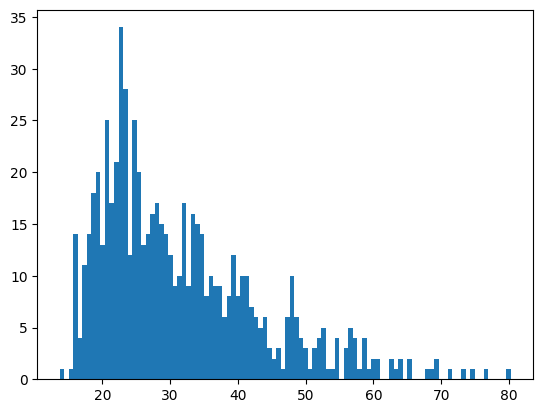

In [466]:
# Column 1: if the distribution is skewed replace '?' with median, otherwise use the mean

col_1_float = cc_apps[1][cc_apps[1] != '?'].astype('float')     # consider only numbers     
col_1_float_mean = col_1_float.mean()
col_1_float_median = col_1_float.median()
print(f'mean = {col_1_float_mean}')
print(f'mean = {col_1_float_median}')

plt.hist(col_1_float, bins=100)
plt.show()

In [467]:
cc_apps[1] = cc_apps[1].replace('?', col_1_float_median)    # the distribution is a bit skewed, so we use the median
cc_apps[1] = cc_apps[1].astype('float')
print(cc_apps[1].describe())

count    690.000000
mean      31.514116
std       11.860245
min       13.750000
25%       22.670000
50%       28.460000
75%       37.707500
max       80.250000
Name: 1, dtype: float64


In [468]:
# Now let's convert columns to binary or dummy, depending on the number of categories

print(cc_apps.select_dtypes('object').describe())   # panoramic of all non-numerical columns

         0    3    4    5    6    8    9    11   13
count   690  690  690  690  690  690  690  690  690
unique    2    2    2   14    5    2    2    3    2
top       b    u    g    c    v    t    f    g    -
freq    480  527  527  146  408  361  395  625  383


In [469]:
col_binary = [0, 3, 4, 8, 9, 13]
col_dummy = [5, 6, 11]

for col in col_binary:
    cc_apps[col] = np.where(cc_apps[col] == cc_apps[col].mode()[0], 0, 1)

cc_apps = pd.get_dummies(cc_apps, columns=col_dummy, drop_first=True)

In [470]:
# Last checks for non-numerical columns

for col in col_binary:
    print('\n', cc_apps[col].value_counts().sort_index())

print(cc_apps.columns)


 0
0    480
1    210
Name: count, dtype: int64

 3
0    527
1    163
Name: count, dtype: int64

 4
0    527
1    163
Name: count, dtype: int64

 8
0    361
1    329
Name: count, dtype: int64

 9
0    395
1    295
Name: count, dtype: int64

 13
0    383
1    307
Name: count, dtype: int64
Index([        0,         1,         2,         3,         4,         7,
               8,         9,        10,        12,        13,     '5_c',
          '5_cc',     '5_d',     '5_e',    '5_ff',     '5_i',     '5_j',
           '5_k',     '5_m',     '5_q',     '5_r',     '5_w',     '5_x',
          '6_ff',     '6_h', '6_other',     '6_v',    '11_p',    '11_s'],
      dtype='object')


We'll also check the distribution of numerical columns to look for anomalies.

In [471]:
print(cc_apps[[1, 2, 7, 10, 12]].describe())   # investigate numerical columns

                1           2           7         10             12
count  690.000000  690.000000  690.000000  690.00000     690.000000
mean    31.514116    4.758725    2.223406    2.40000    1017.385507
std     11.860245    4.978163    3.346513    4.86294    5210.102598
min     13.750000    0.000000    0.000000    0.00000       0.000000
25%     22.670000    1.000000    0.165000    0.00000       0.000000
50%     28.460000    2.750000    1.000000    0.00000       5.000000
75%     37.707500    7.207500    2.625000    3.00000     395.500000
max     80.250000   28.000000   28.500000   67.00000  100000.000000


There is no evidence of anomalies.

In [472]:
# check the final version of our dataset

print(cc_apps.columns)
print(cc_apps.shape)

Index([        0,         1,         2,         3,         4,         7,
               8,         9,        10,        12,        13,     '5_c',
          '5_cc',     '5_d',     '5_e',    '5_ff',     '5_i',     '5_j',
           '5_k',     '5_m',     '5_q',     '5_r',     '5_w',     '5_x',
          '6_ff',     '6_h', '6_other',     '6_v',    '11_p',    '11_s'],
      dtype='object')
(690, 30)


Compute columns correlation to see if we can delete some columns. Set the threshold of 'high correlation' to 0.7.

In [473]:
threshold_corr = 0.7
correlations = cc_apps.corr().abs()
high_correlations = [(i, j, round(correlations.loc[i, j], 2)) for i in correlations.index for j in correlations.columns if i != j and correlations.loc[i, j] > threshold_corr]
print(high_correlations)

[(3, 4, np.float64(1.0)), (4, 3, np.float64(1.0)), (8, 13, np.float64(0.72)), (13, 8, np.float64(0.72)), ('5_ff', '6_ff', np.float64(0.94)), ('6_ff', '5_ff', np.float64(0.94))]


Observations:
- Columns 3 and 4 are strongly correlated (corr 1.0)
- Column 8 is moderate-to-strongly correlated with the target (corr 0.72)
- Columns 5_ff and 6_ff are strongly correlated (corr 0.94)

I am oriented to delete columns 3, 5_ff.

In [474]:
cc_apps = cc_apps.drop([3, '5_ff'], axis=1)
print(cc_apps.columns)
print(cc_apps.shape)

Index([        0,         1,         2,         4,         7,         8,
               9,        10,        12,        13,     '5_c',    '5_cc',
           '5_d',     '5_e',     '5_i',     '5_j',     '5_k',     '5_m',
           '5_q',     '5_r',     '5_w',     '5_x',    '6_ff',     '6_h',
       '6_other',     '6_v',    '11_p',    '11_s'],
      dtype='object')
(690, 28)


Now we'll prepare features, target and a binary classification model.

We will use a Logistic regressor.

In [475]:
X = cc_apps.drop(13, axis=1).values
y = cc_apps[13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()    # model with default parameters
cv_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=4, scoring='accuracy')
print(f'CV scores with default parameters: {cv_scores}, Average: {np.mean(cv_scores)}')

model.fit(X_train_scaled, y_train)
accuracy = model.score(X_test_scaled, y_test)
print(f'Test accuracy with default parameters : {accuracy}')

#print(model.get_params())
param_grid = {'max_iter' : [30, 50, 100, 150], 'C' : [0.001, 0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
print(f'Grid search results: best parameters {gs.best_params_}, best accuracy {gs.best_score_}')
accuracy = gs.best_estimator_.score(X_test_scaled, y_test)
print(f'Test accuracy with optimized parameters : {accuracy}')

CV scores with default parameters: [0.86231884 0.85507246 0.84057971 0.84782609], Average: 0.8514492753623188
Test accuracy with default parameters : 0.8695652173913043
Grid search results: best parameters {'C': 0.01, 'max_iter': 30}, best accuracy 0.855072463768116
Test accuracy with optimized parameters : 0.855072463768116
